# Conditional Volatility and VaR

_The only constant in life is change_ - Heraclitus

Concepts:
- Value at Risk
- Coherence and Expected Shortfall
- Cryptocurrency Indices
- Historical Simulation and Stressed VaR
- Bootstrapping
- EWMA and GARCH
- Backtesting VaR

References:
- Jorion, Phillippe. Value at Risk.
- P. Artzner, F. Delbaen, J.-M. Eber, and D. Heath, "Coherent Measures of Risk", Mathematical Finance 9 (1999): 203–228.
- Kupiec, P. (1995). Techniques for Verifying the Accuracy of Risk Measurement Models. Journal of Derivatives, 3, 73-84.
- FRM Part I Exam Book Ch. 1-3
- FRM Part II Exam Book Market Risk Measurement and Management Ch. 1-2


In [30]:
from typing import Dict
import numpy as np
from scipy import stats
import pandas as pd
from pandas import DataFrame, Series
import statsmodels.api as sm
import matplotlib.pyplot as plt
from finds.readers import Alfred
from finds.utils import row_formatted
from secret import credentials
#pd.set_option('display.max_rows', None)
VERBOSE = 0
#%matplotlib qt

## Value at Risk

Value at Risk (VaR) is an important risk measure that focuses on adverse events and their probability. A VaR with a confidence level  of _alpha_% is found by searching for the loss that has an _alpha_% chance of being exceeded. 


### Coherence

One problem with VaR is that it does not say anything about how bad losses might be when they exceed the VaR level. Furthermore, Artzner et al. proposed four properties a risk measure should have.

1. Monotonicity: If (regardless of what happens) a portfolio always produces a worse result than another portfolio, it should have a higher risk measure.
2. Translation Invariance: If an amount of cash K is added to a portfolio, its risk measure should decrease by K.
3. Homogeneity: Changing the size of a portfolio by multiplying the amounts of all the components by X results in the risk measure being multiplied by X.
4. Subadditivity: For any two portfolios, the risk measure for the portfolio formed by merging them should be no greater than the sum of the risk measures for the portfolios.

A risk measure that satisfies all four conditions is termed coherent. __Expected shortfall__ (ES) has all four properties, while VaR has only the first three properties. ES is computed as the probability-weighted average of tail losses.  Other coherent risk measures can be derived by applying a risk aversion function to weight the quantiles. ES is a special case where the risk aversion weights are equal for all tail-loss quantiles.



In [31]:
# retrieve crypto currency index from FRED, as log returns
alf = Alfred(api_key=credentials['fred']['api_key'], verbose=VERBOSE, convert_date=0)
cat = alf.get_category(33913)
cryptos = [alf(s['id'], log=1, diff=1)
           for s in cat['series'] if 'DISCONT' not in s['title']]
cryptos = pd.concat(cryptos, axis=1).sort_index()
titles = Series({s['id']: s['title']
                 for s in cat['series'] if 'DISCONT' not in s['title']},
                name=cat['name'])

In [32]:
# crypto index names
titles.to_frame().rename_axis(index=cat['id'])

,Cryptocurrencies
33913,
CBBCHUSD,Coinbase Bitcoin Cash
CBBTCUSD,Coinbase Bitcoin
CBETHUSD,Coinbase Ethereum
CBLTCUSD,Coinbase Litecoin


In [33]:
# recent crypto log returns
cryptos.tail()

,CBBCHUSD,CBBTCUSD,CBETHUSD,CBLTCUSD
date,,,,
2024-04-11,-0.020373,-0.007875,-0.010817,0.024184
2024-04-12,-0.141308,-0.042222,-0.080178,-0.138679
2024-04-13,-0.104275,-0.046878,-0.070173,-0.104611
2024-04-14,0.084578,0.024820,0.043828,0.025499
2024-04-15,-0.031220,-0.035412,-0.016538,-0.018678


### Parametric method

Under the assumption that returns normally distributed, VaR and ES at the confidence level _alpha_ is: 

$$VaR = -\mu + \sigma z_{1-\alpha}$$

$$ES = -\mu + \sigma \dfrac{\exp(-z_{1-\alpha}^2/2)}{(1 - \alpha)\sqrt{2 \pi}}$$

where $z_{\alpha}$ is the standard normal variate corresponding to _alpha_. 

For example, with _alpha_ = 0.95, $z_{\alpha} =$ -1.645 which is the value whose cdf is the bottom 5% tail. In practice, $\mu$ and $\sigma$ are not known and must be estimated. Since means are measured less precisely than volatility, and the returns are observed at short intervals, $\mu$ is often assumed to be 0.

The normal probability distribution has skewness (third central moment) equal to zero and kurtosis (fourth central moment) equal to 3. Under the assumption that geometric returns are normally distributed, then arithmetic returns have a __lognormal distributed__. The skewness of the lognormal is 
$(\exp(\sigma^2) + 2)\sqrt{(\exp(\sigma^2) - 1)}$, and is always positive, hence the lognormal has a long right-tail. The lognormal has kurtosis
$\exp(\sigma^2)^4 + 2\exp(\sigma^2)^3 + 3\exp(\sigma^2)^2 -3$ which varies from a minimum of over 3, and hence exhibits fatter tails than the normal.



In [34]:
# Helper to compute parametric VaR and ES
def parametric_risk(sigma: float | Series, alpha: float) -> Dict:
    """Calculate parametric gaussian VaR and ES"""
    var = -sigma * stats.norm.ppf(1 - alpha)
    es = sigma * stats.norm.pdf(stats.norm.ppf(1 - alpha)) / (1 - alpha)
    return dict(value_at_risk=var, expected_shortfall=es)

In [35]:
alpha = 0.95
volatility = {label: np.std(cryptos[label]) for label in cryptos}
parametric = DataFrame({label: Series(parametric_risk(std, alpha=alpha))
                        for label, std in volatility.items()})
print(f"Parametric Risk Measures (alpha={alpha})")
pd.concat([DataFrame.from_dict({'volatility': volatility}, orient='index'),
           parametric], axis=0).round(4)

Parametric Risk Measures (alpha=0.95)


,CBBCHUSD,CBBTCUSD,CBETHUSD,CBLTCUSD
volatility,0.0597,0.0407,0.0520,0.0557
value_at_risk,0.0982,0.0669,0.0855,0.0916
expected_shortfall,0.1232,0.0839,0.1072,0.1149


### Delta-Normal method

This model is used to provide an approximate results for non-linear portfolios. The underlying assets or risk factors are modeled with a normal distribution. The risk of a portfolio, which may exhibit non-linear payoffs with options securities, is modeled by its delta, or the instantaneous rate of change in its value with respect to the rate of change in the underlying. A better approximation includes the second derivative of the portfolio value with the underlying assets or risk factors, called the delta-gamma method.



### Monte Carlo Simulation method

Monte Carlo simulation works for both linear and non-linear portfolios.
This method generates scenarios by taking random samples from the normal (or other theoretical) distribution assumed for the underlying assets or risk factors. Suppose 1000 MC scenarios are simulated: the VaR with _alpha_ = 95% confidence will be the 50th (i.e. 5th percentile) worst loss and expected shortfall is the average of the 49 losses worse than this.



However, simple models based on Gaussian and independence assumptions may not be appropriate for the data sample, requiring the consideration of __non-parametric__ approaches.

The QQ plot compare the distribution of the data sample to a reference normal distribution. The plot would appear linear when the observed quantiles are close to the theoretical quantiles. If the empirical distribution has heavier tails than the reference distribution, the QQ plot will have steeper slopes at its tails.




/home/terence/env3.11/lib/python3.11/site-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


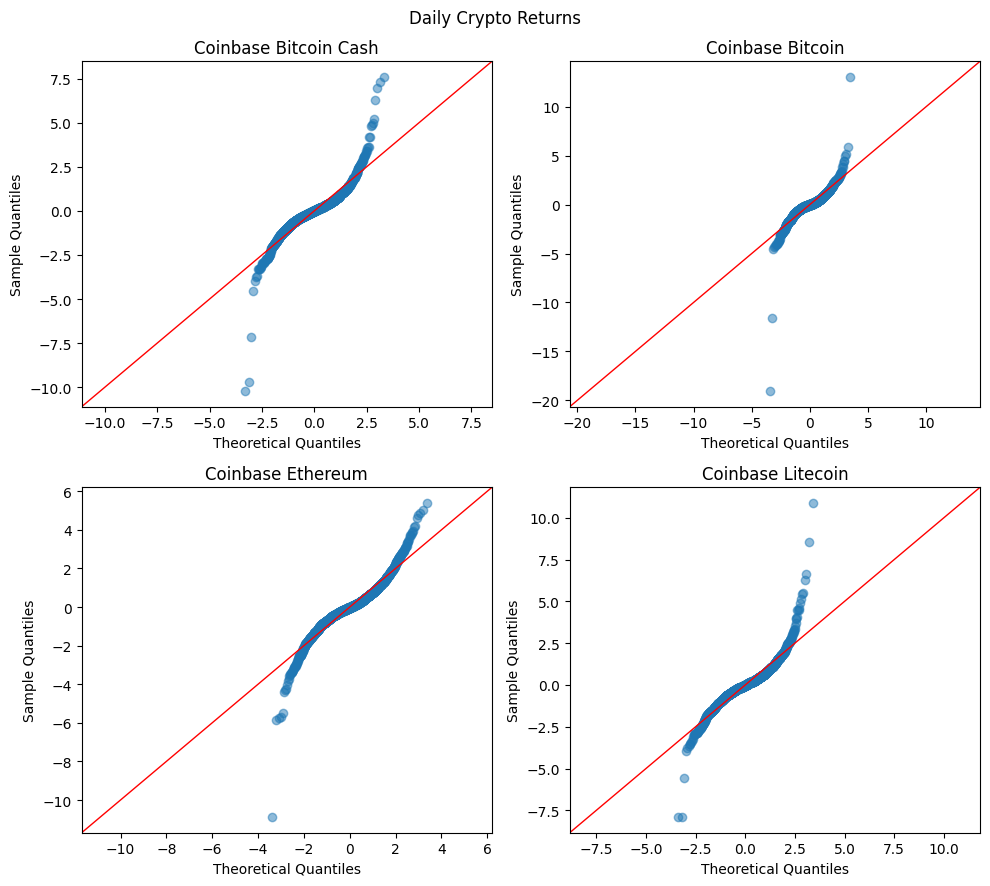

In [65]:
# QQ Plot for Gaussian assumption
from statsmodels.graphics.gofplots import ProbPlot
fig, axes = plt.subplots(2, 2, figsize=(10, 9))
for label, ax in zip(cryptos, axes.flatten()):
    pp = ProbPlot(cryptos[label].dropna(), fit=True)
    pp.qqplot(ax=ax, color='C0', alpha=.5)
    sm.qqline(ax=ax, fmt='r--', line='45', lw=1)
    ax.set_title(f"{titles[label]}")
plt.suptitle(f"Daily Crypto Returns")
plt.tight_layout()

Lagplot of daily returns

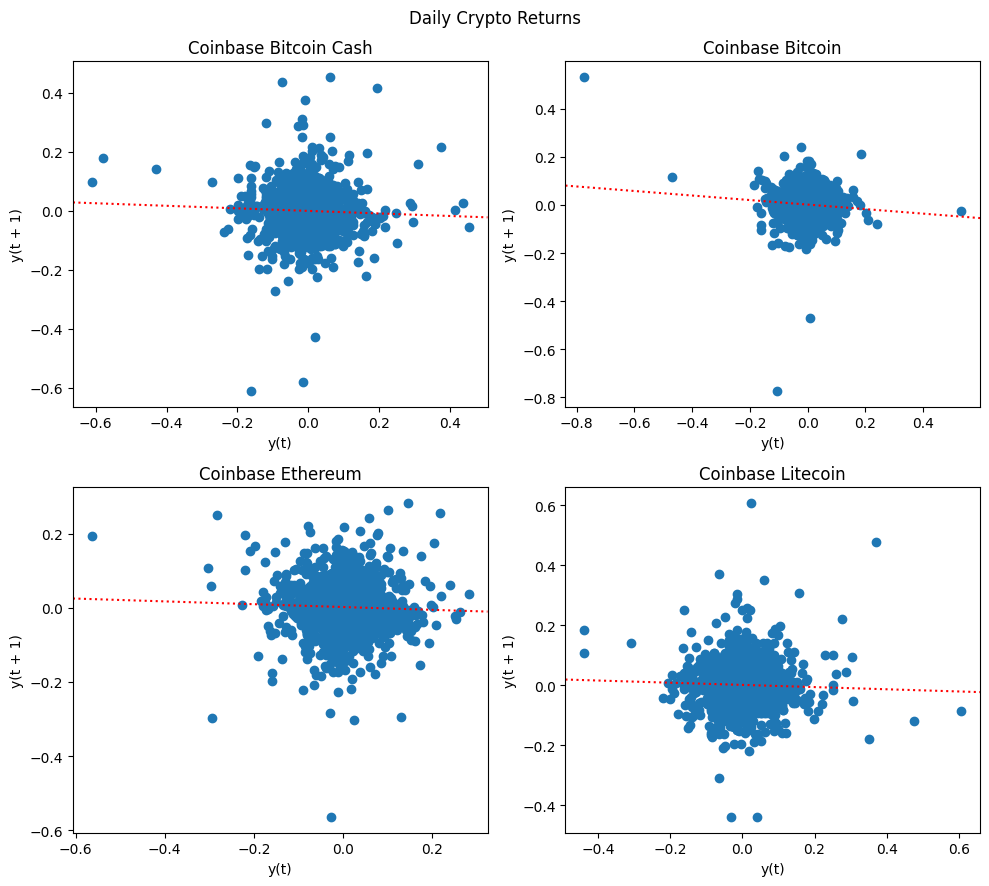

In [37]:
# Autocorrelation of returns
import statsmodels.api as sm
fig, axes = plt.subplots(2, 2, figsize=(10, 9))
for label, ax in zip(cryptos, axes.flatten()):
    X = cryptos[label].dropna()
    pd.plotting.lag_plot(X, lag=1, ax=ax)
    r = stats.linregress(X.values[1:], X.values[:-1])
    ax.axline((0, r.intercept), slope=r.slope, ls=':', color="red")    
    ax.set_title(f"{titles[label]}")
plt.suptitle(f"Daily Crypto Returns")
plt.tight_layout()

Lagplot of squared daily returns

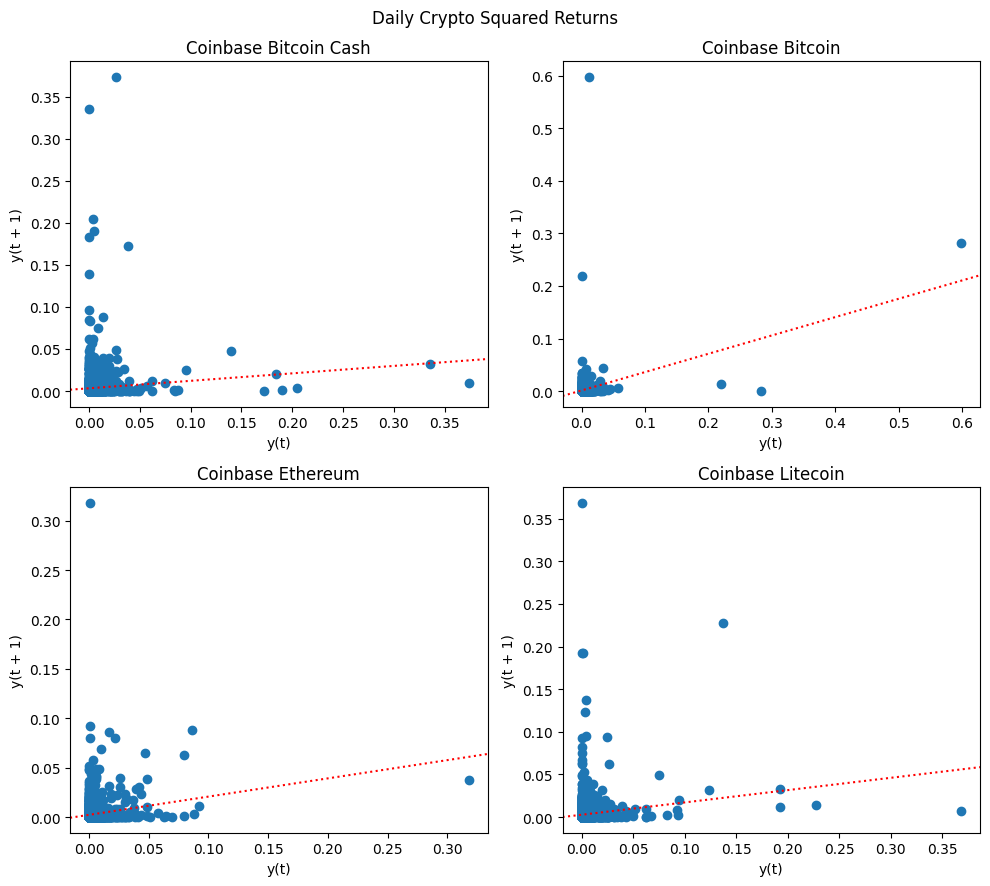

In [38]:
# Autocorrelation of squared returns
fig, axes = plt.subplots(2, 2, figsize=(10, 9))
for label, ax in zip(cryptos, axes.flatten()):
    X = cryptos[label].dropna()**2
    pd.plotting.lag_plot(X, lag=1, ax=ax)
    r = stats.linregress(X.values[1:], X.values[:-1])
    ax.axline((0, r.intercept), slope=r.slope, ls=':', color="red")    
    ax.set_title(f"{titles[label]}")
plt.suptitle(f"Daily Crypto Squared Returns")
plt.tight_layout()

### Historical Simulation method

The simplest non-parametric approach to estimate VaR is by means of historical simulation (HS). The HS approach estimates VaR by ordering the loss observations and reading off the required VaR quantile. Expected shortfall is computed by averaging the observations smaller than that quantile.  Since non-parametric approaches do not depend on  assumptions about the model distribution, they can accommodate fat tails, skewness, and any other non-normal features that can cause problems for parametric approaches. However, non-parametric approaches are affected by how representative of data sample is of the period to be measured.



In [39]:
# Helper to compute VaR, ES and sample moments from historical simulation
def historical_risk(X: Series, alpha: float):
    """Calculate historical VaR, ES, and sample moments"""
    X = X.dropna()
    N = len(X)
    var = -np.percentile(X, 100 * (1 - alpha))
    es = -np.mean(X[X < var])
    vol = np.std(X, ddof=0)
    skew = stats.skew(X)
    kurt = stats.kurtosis(X)
    jb = stats.jarque_bera(X)[0]
    jbp = stats.jarque_bera(X)[1]
    return dict(N=N, value_at_risk=var, expected_shortfall=es, volatility=vol,
                skewness=skew, excess_kurtosis=kurt-3, jb_statistic=jb, jb_pvalue=jbp)

In [40]:
hist = DataFrame({label: historical_risk(cryptos[label], alpha=alpha)
                  for label in cryptos})
print(f"Historical Risk Measures (alpha={alpha})")
row_formatted(hist.round(4), {'N': "{:.0f}"})

Historical Risk Measures (alpha=0.95)


,CBBCHUSD,CBBTCUSD,CBETHUSD,CBLTCUSD
N,2302,3388,2886,2796
value_at_risk,0.0844,0.0606,0.0764,0.0836
expected_shortfall,0.0082,0.0031,0.0054,0.0064
volatility,0.0597,0.0407,0.052,0.0557
skewness,-0.2437,-1.8572,-0.4497,0.7674
excess_kurtosis,12.8465,51.3866,5.8203,10.2764
jb_statistic,24108.4383,419504.1796,9452.3917,20809.0086
jb_pvalue,0.0,0.0,0.0,0.0


### Stressed VaR method

Volatilities increase during stressed market conditions, and  correlations also generally increase. It is sometimes stated that "in stressed markets all correlations go to one." In periods of heightened volatility such as the Great Financial Crisis of 2008, correlations can be quite different from those in normal market conditions. This is sometimes referred to as a correlation break-down. When concerned with estimating what will happen in extreme market conditions, VaR or ES should be estimated based what correlations will be in such conditions rather than in normal market conditions.

Stress testing is designed to identify vulnerabilities, particularly those involving high volatility. __Stressed VaR__ is computed based on a "stressed" historical period in the markets, as opposed to simply the most recent number of years, to get an idea of possible losses given worse market conditions. For example, the period from Nov 2021 through November 21, 2022 has been dubbed the "crypto winter", culminating with collapse of the FTX crypto exchange.


In [41]:
beg, end = '2021-11-01', '2022-11-21'  # dubbed "crypto winter"
stress = DataFrame({label: historical_risk(cryptos.loc[beg:end, label], alpha=alpha)
                    for label in cryptos})
print(f"Stressed Risk Measures ({beg} to {end})")
row_formatted(stress.round(4).rename_axis(index='(alpha=0.05)'), {'N': "{:.0f}"})

Stressed Risk Measures (2021-11-01 to 2022-11-21)


,CBBCHUSD,CBBTCUSD,CBETHUSD,CBLTCUSD
(alpha=0.05),,,,
N,386,386,386,386
value_at_risk,0.0818,0.0624,0.0773,0.0911
expected_shortfall,0.0078,0.0058,0.0074,0.0053
volatility,0.0464,0.0348,0.0461,0.0478
skewness,-0.3194,-0.5904,-0.3785,-0.417
excess_kurtosis,-0.5048,0.7985,-0.6065,-1.0258
jb_statistic,106.6976,254.4822,101.3559,73.8708
jb_pvalue,0.0,0.0,0.0,0.0


### Bootstrap method

One simple but powerful improvement over basic HS is to estimate VaR and ES from bootstrapped data. The bootstrap procedure involves resampling from the existing data set with replacement.  Each new ‘resampled’ sample gives us a new VaR estimate, and their mean can be taken to be the best estimate, with standard error and confidence interval computed from the distribution of resample-based estimates. We can also use the bootstrap to estimate ES's in much the same way.

Perhaps the main limitation of the bootstrap is that standard bootstrap procedures presuppose that observations are independent over time.  There are various way to modify bootstraps to allow for such dependence, such as the block approach: Divide sample data into non-overlapping blocks of equal length, and select a block at random. 


In [42]:
def bootstrap_risk(X: Series, alpha: float, n: int) -> dict:
    """Calculate bootstrap VaR, ES, confidence and plot VaR histogram"""
    X = X.dropna()
    N = len(X)
    bootstraps = []
    for _ in range(n):
        Z = Series(np.random.choice(X, N), index=X.index)
        bootstraps.append(historical_risk(Z, alpha=alpha))
    bootstraps = DataFrame.from_records(bootstraps)
    return bootstraps

In [43]:
def confidence_intervals(X: Series, confidence: float) -> dict:
    """Extracts confidence intervals and median from a series"""
    lower = (1 - confidence) / 2
    upper = lower + confidence
    return np.quantile(X, [lower, 0.5, upper], method='inverted_cdf')

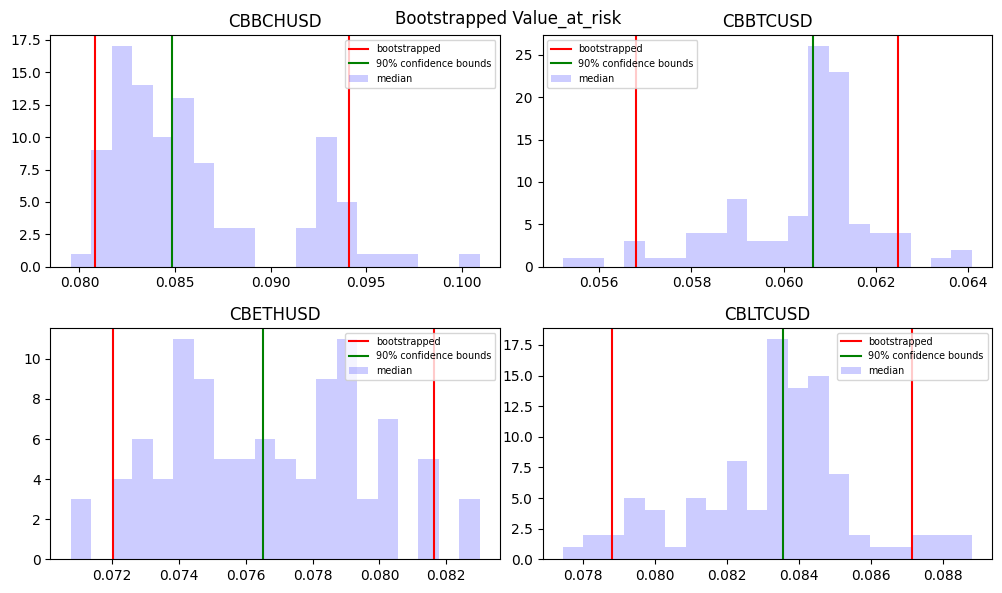

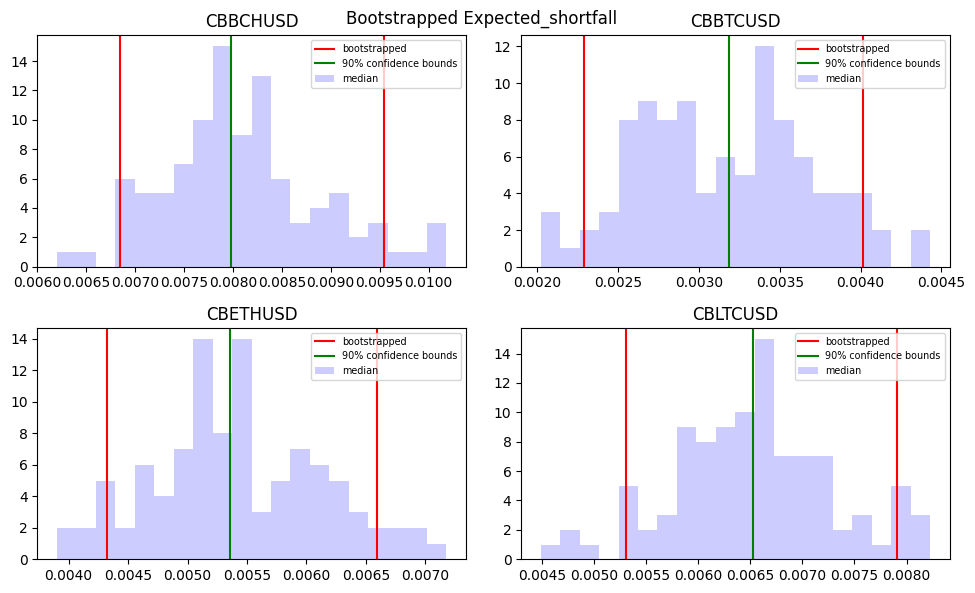

In [44]:
# Run and plot bootstrapped VaR and ES
n = 100
confidence = 0.9
intervals = dict()
for measure in ['value_at_risk', 'expected_shortfall']:
    intervals[measure] = dict()
    fig, axes = plt.subplots(2, 2, figsize=(10, 6))
    for label, ax in zip(cryptos, axes.flatten()):
        bootstraps = bootstrap_risk(cryptos[label].dropna(), alpha=alpha, n=n)
        interval = confidence_intervals(bootstraps[measure], confidence=confidence)
        intervals[measure][label] = interval.tolist()
        ax.hist(bootstraps[measure], color='blue', alpha=0.2, bins=int(n/5))
        ax.axvline(x=interval[0], color='red')
        ax.axvline(x=interval[1], color='green')
        ax.legend(['bootstrapped', f"{confidence*100:.0f}% confidence bounds",
                   'median'], fontsize='x-small')
        ax.axvline(x=interval[2], color='red')
        ax.set_title(label)
    plt.tight_layout()
    plt.suptitle('Bootstrapped ' + measure.capitalize())

In [45]:
# display confidence intervals of VaR
DataFrame(intervals['value_at_risk'], index=['lower', 'median', 'upper'])\
    .rename_axis(index='Value at Risk')

,CBBCHUSD,CBBTCUSD,CBETHUSD,CBLTCUSD
Value at Risk,,,,
lower,0.080831,0.056794,0.072047,0.078821
median,0.084858,0.060644,0.076511,0.083562
upper,0.094109,0.062483,0.081622,0.087124


In [46]:
# display confidence intervals of VaR
DataFrame(intervals['expected_shortfall'], index=['lower', 'median', 'upper'])\
    .rename_axis(index='Expected Shortfall')

,CBBCHUSD,CBBTCUSD,CBETHUSD,CBLTCUSD
Expected Shortfall,,,,
lower,0.006844,0.002288,0.004324,0.005304
median,0.007976,0.003185,0.005357,0.006525
upper,0.009545,0.004016,0.006594,0.007911


## Conditional volatility models

A return distribution may have parameters that vary through time. For ample, a simple mixture model of two normal distributions with different volatilities exhibits more peakedness and fatter tails than the normal. It is important to distinguish between a model where returns are unconditionally normal and a model where they are conditionally normal. In the latter, the return distribution is normal each day, while the standard deviation of the return varies throughout time (in other words, volatility is stochastic). During some periods it is high; during other periods it is low. This leads to an unconditional distribution with fat tails.

### EWMA model

Current volatility can be estimated as an equal-weighted average of recent squared returns. This makes a simplifying assumption that the expected return is 0, which is reasonable over short periods such as daily where the standard deviation of the return is much more important than the mean. One problem with using an equal average is that a large (squared) return entering or dropping out of the sample is that the volatility will experience a large one-day increase or drop. 

One way of overcoming these problems is to use exponential smoothing,  which is also referred to as the exponentially weighted moving average (EWMA).  In EWMA, the weight applied to the squared return from $k$ days ago is $\lambda$ multiplied by the weight applied to the squared return $k-1$ days ago (where $\lambda$ is a positive constant that is less than one). In the 1990s, the JP Morgan RiskMetrics group used this approach and found that setting $\lambda=0.94$ proved a good choice for estimating volatilies of a wide range of market variables.  The EWMA estimate can be conveniently expressed as a recursive equation:

$$\sigma^2_t = (1 - \lambda) r^2_{t-1} + \lambda \sigma^2_{t-1}$$

This formula provides a very simple way of implementing EWMA. The new estimate of the variance rate on day n is a weighted average of he estimate of the variance rate made for the previous day $(n - 1)$, and
the most recent observation of the squared return on day $(n - 1)$.



In [47]:
# Estimate EWMA (lambda=0.94) rolling model predictions for all cryptos
lambda_ = 0.94
ewma = {label: np.sqrt((cryptos[label]**2).dropna().ewm(alpha=1-lambda_).mean())
        for label in cryptos}

In [48]:
# Helper to plot predicted VaR vs actual returns
def plot_var(X: Series, VaR: Series, ax: plt.Axes):
    """Helper to plot returns and VaR predictions"""
    ax.plot(X, ls='', marker='.', markersize=2)
    ax.plot(-VaR.shift(-1), lw=1, ls='-', c='r')
    ax.plot(VaR.shift(-1), lw=1, ls='-', c='r')
    ax.legend([X.name, 'VaR', '$-$VaR'])

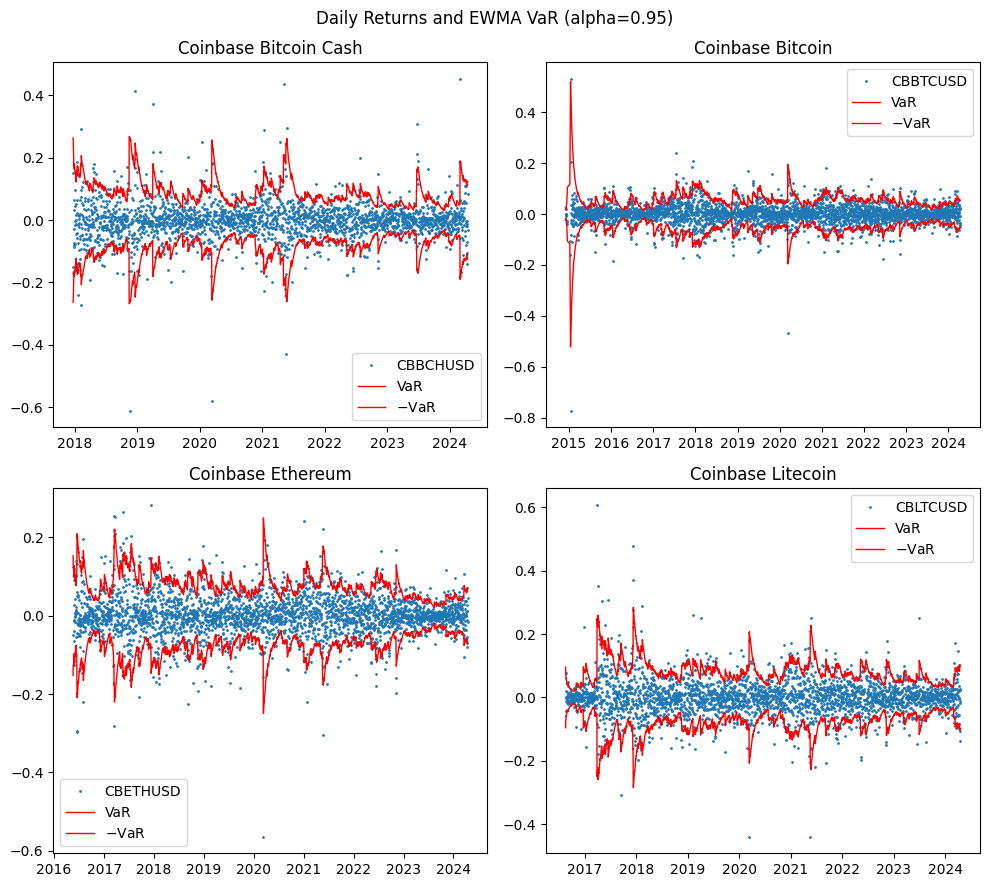

In [59]:
# Plot daily returns and EWMA predicted VaR of all cryptos
fig, axes = plt.subplots(2, 2, figsize=(10, 9))
for label, ax in zip(cryptos, axes.flatten()):
    Z = pd.concat([cryptos[label].dropna(),
                   parametric_risk(ewma[label], alpha=alpha)['value_at_risk']\
                   .rename('VaR')],
                  join='inner', axis=1).dropna()
    plot_var(Z[label], VaR=Z['VaR'], ax=ax)
    ax.set_title(titles[label])
plt.suptitle(f"Daily Returns and EWMA VaR (alpha={alpha})")
plt.tight_layout()

In [50]:
# Properties of EWMA normalized returns for all cryptos
ewma_hist = dict()
for label in cryptos:
    X = (cryptos[label] / ewma[label].shift(-1))  # normalize by predict vol
    ewma_hist[label] = Series(historical_risk(X, alpha=0.95)).rename(label)
print("Normalized by EWMA predicted volatility (alpha=0.95)")
DataFrame(ewma_hist).round(4)

Normalized by EWMA predicted volatility (alpha=0.95)


,CBBCHUSD,CBBTCUSD,CBETHUSD,CBLTCUSD
N,2301.0000,3387.0000,2885.0000,2795.0000
value_at_risk,1.5056,1.4689,1.5831,1.5682
expected_shortfall,0.1249,0.0673,0.0778,0.0922
volatility,0.9260,0.9220,0.9417,0.9416
skewness,0.1289,-0.0729,-0.0307,0.0187
excess_kurtosis,-1.3967,-1.4662,-2.1265,-1.7600
jb_statistic,252.8316,334.9892,92.1766,179.2390
jb_pvalue,0.0000,0.0000,0.0000,0.0000


### GARCH model

The generalized autoregressive conditional heteroskedasticity or __GARCH__ model, developed by Robert Engel and Tim Bollerslev, can be intuitively regarded as an extension of EWMA. In GARCH (1,1), we also give some weight to a long run average variance rate $\hat{\sigma}$. The updated formula for the variance rate is:

$$\sigma^2_t = \alpha r^2_{t-1} + \beta \sigma^2_{t-1} + \gamma \hat{\sigma}$$

The weights must be sum to one, hence $\alpha + \beta \le 1$ and $\gamma = 1 - \alpha - \beta$.

GARCH (1,1), compared to EWMA, incorporate mean-reversion where the $\hat{\sigma}$ term provides a “pull” toward the long-run average mean. And just as with ARMA specifications of time series models, GARCH(p,q) can incorporate additional lags of $q$ squared returns and $p$ previous variance rate estimates to generate better fitting models. 

In [51]:
# Estimate GARCH(1, 1) by calling R's rugarch library
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from finds.utils import PyR
def rugarch(X: Series, savefig: str = '', verbose=VERBOSE) -> Series:
    """GARCH(1,1) wrapper around rugarch"""
    rugarch_ro = importr('rugarch')  # to use library rugarch
    c_ = ro.r['c']
    list_ = ro.r['list']
    spec = ro.r['ugarchspec'](mean_model=list_(armaOrder=c_(0,0), include_mean=False))
    model = ro.r['ugarchfit'](spec, data=PyR(X.values).ro)
    if verbose:
        ro.r['show'](model)
    if savefig:
        for which in [4, 5, 10, 11]:
            ro.r['plot'](model, which=which)
            PyR.savefig(f"{savefig}{which}.png", display=None)
    return Series(PyR(ro.r['sigma'](model)).values.flatten(),
                  index=X.index, name=X.name)

In [52]:
# Estimate GARCH(1,1) full period model for all cryptos
garch = {label: rugarch(cryptos[label].dropna()) for label in cryptos}

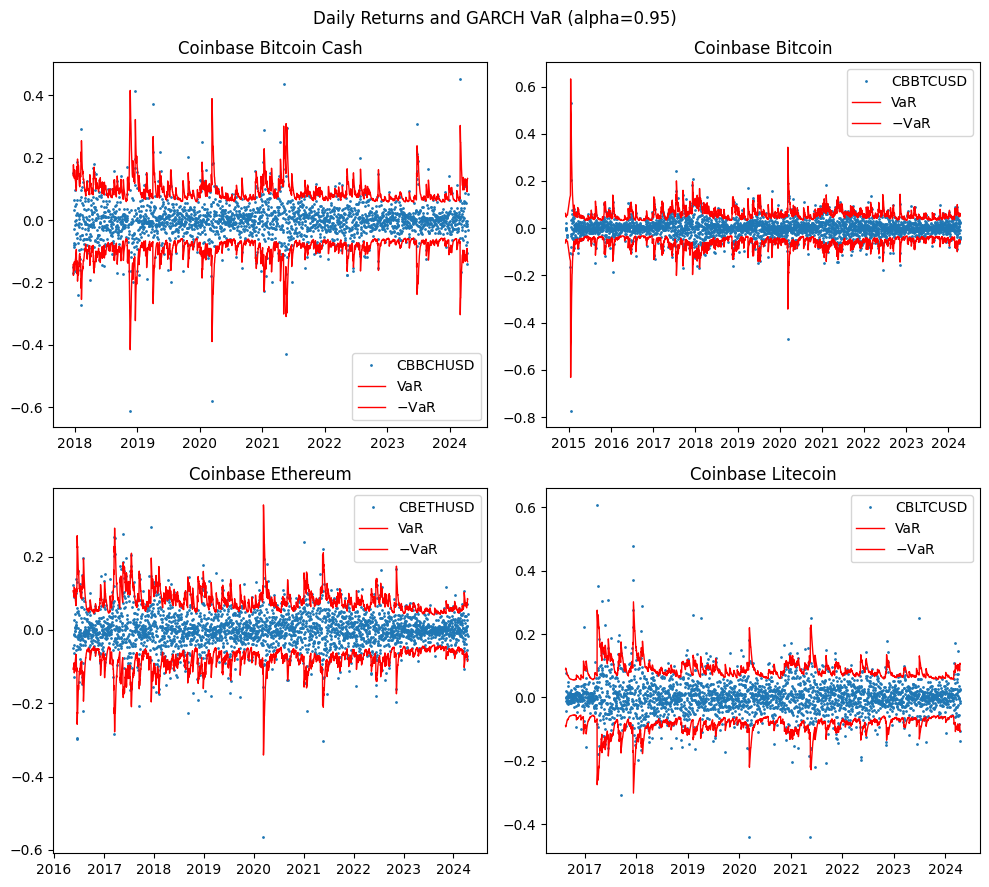

In [60]:
# Plot daily returns and GARCH predicted VaR
alpha = 0.95   # VaR parameter
fig, axes = plt.subplots(2, 2, figsize=(10, 9))
for label, ax in zip(cryptos, axes.flatten()):
    Z = pd.concat([cryptos[label],
                   parametric_risk(garch[label], alpha=alpha)['value_at_risk']\
                   .rename('VaR')],
                  join='inner', axis=1).dropna()
    plot_var(Z[label], VaR=Z['VaR'], ax=ax)
    ax.set_title(titles[label])
plt.suptitle(f"Daily Returns and GARCH VaR (alpha={alpha})")
plt.tight_layout()

In [54]:
# Properties of GARCH normalized returns
garch_hist = dict()
for label in cryptos:
    X = (cryptos[label] / garch[label].shift(-1))  # normalize by predict vol
    garch_hist[label] = Series(historical_risk(X, alpha=0.95)).rename(label)
print("Normalized by GARCH predicted volatility (alpha=0.95)")
DataFrame(garch_hist).round(4)

Normalized by GARCH predicted volatility (alpha=0.95)


,CBBCHUSD,CBBTCUSD,CBETHUSD,CBLTCUSD
N,2301.0000,3387.0000,2885.0000,2795.0000
value_at_risk,1.3172,1.2899,1.4004,1.4004
expected_shortfall,0.1053,0.0467,0.0755,0.0844
volatility,0.7728,0.7654,0.8372,0.8437
skewness,0.0286,-0.0493,-0.0064,0.0512
excess_kurtosis,-2.6270,-2.8977,-2.8001,-1.8373
jb_statistic,13.6517,2.8470,4.8221,158.6495
jb_pvalue,0.0011,0.2409,0.0897,0.0000


## Backtesting VaR

The simplest method to verify the accuracy of the model is to record the failure rate, which gives the proportion of times VaR is exceeded in a given sample. The number of violations or exceptions should follow a binomial distribution with probability of failure $p = 1 - \alpha$, where _alpha_ is the VaR confidence level.  The VaR model can be rejected in two regions, both when the number of observed violations is too few or too many.

### Kupiec Likelihood Ratio test

Kupiec (1995) develops approximate 95 percent confidence regions for such a test, based on by the (two-sided) tail points of the log-likelihood ratio:

$$LR = -2 [(N - S) \ln(1 - p) + S \ln(p)] + 2 [(N - S) \ln(1 - S/N) + S \ln(S/N)]  $$



In [55]:
def kupiec_LR(alpha: float, s: int, n: int):
    """Compute Kupiec likelihood ratio given s violations in n trials

    Returns:
        Dict of likelihood statistic and pvalue
    """
    p = 1 - alpha       # prob of violation
    num = np.log(1 - p)*(n - s) + np.log(p)*s
    den = np.log(1 - (s/n))*(n - s) + np.log(s/n)*s
    lr = -2 * (num - den)
    return {'lr': lr, 'violations': s, 'N': n,
            # '5%_critical': stats.chi2.ppf(0.95, df=1),
            'pvalue': 1 - stats.chi2.cdf(lr, df=1)}

In [56]:
def kupiec(X: Series, VaR: Series, alpha: float) -> Dict:
    """Kupiec Likelihood Ratio test of VaR

    Returns:
        Dict of likelihood statistic and pvalue
    """
    Z = pd.concat([X, VaR], axis=1).dropna()
    n = len(Z)
    s = np.sum(Z.iloc[:, 0] < -Z.iloc[:, 1])  # number of violations < -VaR
    return kupiec_LR(alpha=alpha, s=s, n=n)

In [63]:
# Kupiec likelihood ratio test for EWMA
row_formatted(DataFrame(
    {label: kupiec(cryptos[label],
                   VaR=parametric_risk(ewma[label], alpha=alpha)['value_at_risk'],
                   alpha=alpha) for label in cryptos})\
              .rename_axis(index=f"EWMA({lambda_})", columns="Kupiec LR Test:").round(4),
              {'N': '{:.0f}', 'violations': '{:.0f}'})

Kupiec LR Test:,CBBCHUSD,CBBTCUSD,CBETHUSD,CBLTCUSD
EWMA(0.94),,,,
lr,1.6293,3.2575,1.3298,2.7826
violations,102,147,131,121
N,2302,3388,2886,2796
pvalue,0.2018,0.0711,0.2488,0.0953


In [64]:
# Kupiec likelihood ratio test for GARCH(1,1)
row_formatted(DataFrame(
    {label: kupiec(cryptos[label],
                   VaR=parametric_risk(garch[label], alpha=alpha)['value_at_risk'],
                   alpha=alpha) for label in cryptos})\
              .rename_axis(index=f"GARCH(1,1)", columns="Kupiec LR Test:").round(4),
              {'N': '{:.0f}', 'violations': '{:.0f}'})

Kupiec LR Test:,CBBCHUSD,CBBTCUSD,CBETHUSD,CBLTCUSD
"GARCH(1,1)",,,,
lr,5.2248,5.302,3.8198,10.5494
violations,92,141,122,104
N,2302,3388,2886,2796
pvalue,0.0223,0.0213,0.0507,0.0012


### Conditional coverage tests

This framework focuses on unconditional coverage because it ignores  time variation in the data. In theory, the exceptions should be evenly spread over time.  The observations could cluster or “bunch” closely in time, which also may invalidate the model. The LR statistic can be extended to specify that the deviations must be serially independent.


In [ ]:
# TODO: conditional likelihood test